In [69]:
# Importing libraries
import geopandas as gpd
import os
import pandas as pd
import regex as re
import openpyxl
import matplotlib.pyplot as plt

In [111]:
# Construct the path to the shapefile using the os module
base_dir = os.getcwd()
shapefile_path = os.path.join(base_dir, '..', 'data', 'nyct2020_24b', 'nyct2020.shp')

# Load the shapefile using geopandas
gdf = gpd.read_file(shapefile_path)

# Clean up the GeoDataFrame (remove gibberish rows manually inspected in the CSV)
# We filter out the rows that have gibberish in the 'BoroName' column
gdf = gdf[gdf['BoroName'].isin(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'])]

# Ensure CTLabel and BoroCode are strings
gdf['CTLabel'] = gdf['CTLabel'].astype(str)
gdf['BoroCode'] = gdf['BoroCode'].astype(str)

# Format CTLabel to have two decimal places
gdf['CTLabel'] = gdf['CTLabel'].apply(lambda x: f"{float(x):.2f}")

# Create a "Key" column in gdf
gdf['Key'] = gdf['CTLabel'] + '-' + gdf['BoroCode']

# Change the area to km^2 instead of m^2 
gdf['Shape_Area'] = gdf['Shape_Area'] / 10**6

# Inspect the first few rows of the cleaned GeoDataFrame
print(gdf.head())

  CTLabel BoroCode   BoroName  CT2020 BoroCT2020 CDEligibil  \
0    1.00        1  Manhattan  000100    1000100       None   
1    2.01        1  Manhattan  000201    1000201       None   
2    6.00        1  Manhattan  000600    1000600       None   
3   14.01        1  Manhattan  001401    1001401       None   
4   14.02        1  Manhattan  001402    1001402       None   

                                             NTAName NTA2020 CDTA2020  \
0  The Battery-Governors Island-Ellis Island-Libe...  MN0191     MN01   
1                              Chinatown-Two Bridges  MN0301     MN03   
2                              Chinatown-Two Bridges  MN0301     MN03   
3                                    Lower East Side  MN0302     MN03   
4                                    Lower East Side  MN0302     MN03   

                                            CDTANAME        GEOID  PUMA  \
0  MN01 Financial District-Tribeca (CD 1 Equivalent)  36061000100  4121   
1   MN03 Lower East Side-Chinato

In [109]:
gdf.to_csv('temp.csv')

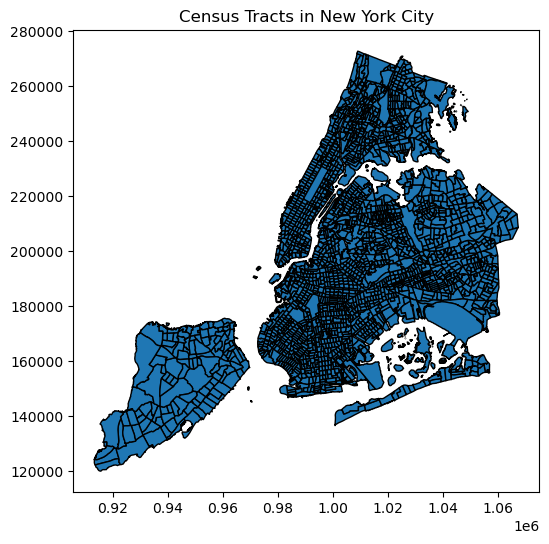

EPSG:2263


In [100]:
# Plot the shapefile to check for completeness
fig, ax = plt.subplots(1, 1, figsize=(8,6))
gdf.plot(ax=ax, edgecolor='k')
ax.set_title('Census Tracts in New York City')
plt.show()

# Check CRS
print(gdf.crs)

In [106]:
# Read the NYC population csv
pop_df = pd.read_csv(os.path.join(base_dir, '..', 'data', 'nyc_census_tract_population.csv'))
pop_df.head(5)

,P1_001N,NAME,state,county,tract
0,3424,"Census Tract 92.02, Kings County, New York",36,47,9202
1,3127,"Census Tract 94.01, Kings County, New York",36,47,9401
2,3168,"Census Tract 94.02, Kings County, New York",36,47,9402
3,6462,"Census Tract 96, Kings County, New York",36,47,9600
4,7440,"Census Tract 98, Kings County, New York",36,47,9800


In [112]:
# Split the NAME column to 3 columns based on the comma separator
pop_df[['CTLabel', 'County', 'StateName']] = pop_df['NAME'].str.split(',', expand=True)

# Strip leading and trailing whitespace from the new columns
pop_df['County'] = pop_df['County'].str.strip()

# Create the county to borough mapping dictionary
county_borough_mapping = {
    "New York County": "Manhattan",
    "Kings County": "Brooklyn",
    "Bronx County": "Bronx",
    "Richmond County": "Staten Island",
    "Queens County": "Queens"
}

# Map the County to Borough
pop_df['Borough'] = pop_df['County'].map(county_borough_mapping)

# BoroCode mapping
borough_code_mapping = {
    "Manhattan": "1",
    "Brooklyn": "3",
    "Bronx": "2",
    "Queens": "4",
    "Staten Island": "5"
}

# Map Borough to BoroCode
pop_df['BoroCode'] = pop_df['Borough'].map(borough_code_mapping)

# Extract the numeric values from CTLabel using regex
pop_df['CTLabelNumeric'] = pop_df['CTLabel'].str.extract(r'(\d+\.\d+|\d+)')

# Convert CTLabelNumeric to numeric type (float) for consistency
pop_df['CTLabelNumeric'] = pd.to_numeric(pop_df['CTLabelNumeric'])

# Format CTLabelNumeric to have two decimal places
pop_df['CTLabelNumeric'] = pop_df['CTLabelNumeric'].apply(lambda x: f"{x:.2f}")

# Create a "Key" column in pop_df
pop_df['Key'] = pop_df['CTLabelNumeric'] + '-' + pop_df['BoroCode']

# Inspect the first few rows of the cleaned population DataFrame
pop_df.head(5)

,P1_001N,NAME,state,county,tract,CTLabel,County,StateName,Borough,BoroCode,CTLabelNumeric,Key
0,3424,"Census Tract 92.02, Kings County, New York",36,47,9202,Census Tract 92.02,Kings County,New York,Brooklyn,3,92.02,92.02-3
1,3127,"Census Tract 94.01, Kings County, New York",36,47,9401,Census Tract 94.01,Kings County,New York,Brooklyn,3,94.01,94.01-3
2,3168,"Census Tract 94.02, Kings County, New York",36,47,9402,Census Tract 94.02,Kings County,New York,Brooklyn,3,94.02,94.02-3
3,6462,"Census Tract 96, Kings County, New York",36,47,9600,Census Tract 96,Kings County,New York,Brooklyn,3,96.00,96.00-3
4,7440,"Census Tract 98, Kings County, New York",36,47,9800,Census Tract 98,Kings County,New York,Brooklyn,3,98.00,98.00-3


In [113]:
# Merge the GeoDataFrame and population DataFrame on the "Key" column
merged_gdf = gdf.merge(pop_df, on='Key', how='inner')

# Check the number of rows in the merged DataFrame
print(f"Number of rows in the merged DataFrame: {merged_gdf.shape[0]}")

# Inspect the first few keys of the merged DataFrame
print(merged_gdf['Key'].head())

Number of rows in the merged DataFrame: 2325
0     1.00-1
1     2.01-1
2     6.00-1
3    14.01-1
4    14.02-1
Name: Key, dtype: object


In [114]:
# Find keys that exist in pop_df but not in merged_gdf
keys_pop_df = set(pop_df['Key'])
keys_merged_gdf = set(merged_gdf['Key'])

missing_keys = keys_pop_df - keys_merged_gdf

# Display the missing keys
print(f"Length of missing keys is {len(missing_keys)} and the set is: {missing_keys}")

Length of missing keys is 2 and the set is: {'9901.00-3', '9901.00-4'}


In [115]:
# Filter the rows in pop_df with the missing keys to inspect them
missing_rows = pop_df[pop_df['Key'].isin(missing_keys)]
print(missing_rows[['Key', 'P1_001N', 'County', 'Borough', 'BoroCode']])


            Key  P1_001N         County   Borough BoroCode
1165  9901.00-3        0   Kings County  Brooklyn        3
2088  9901.00-4        0  Queens County    Queens        4


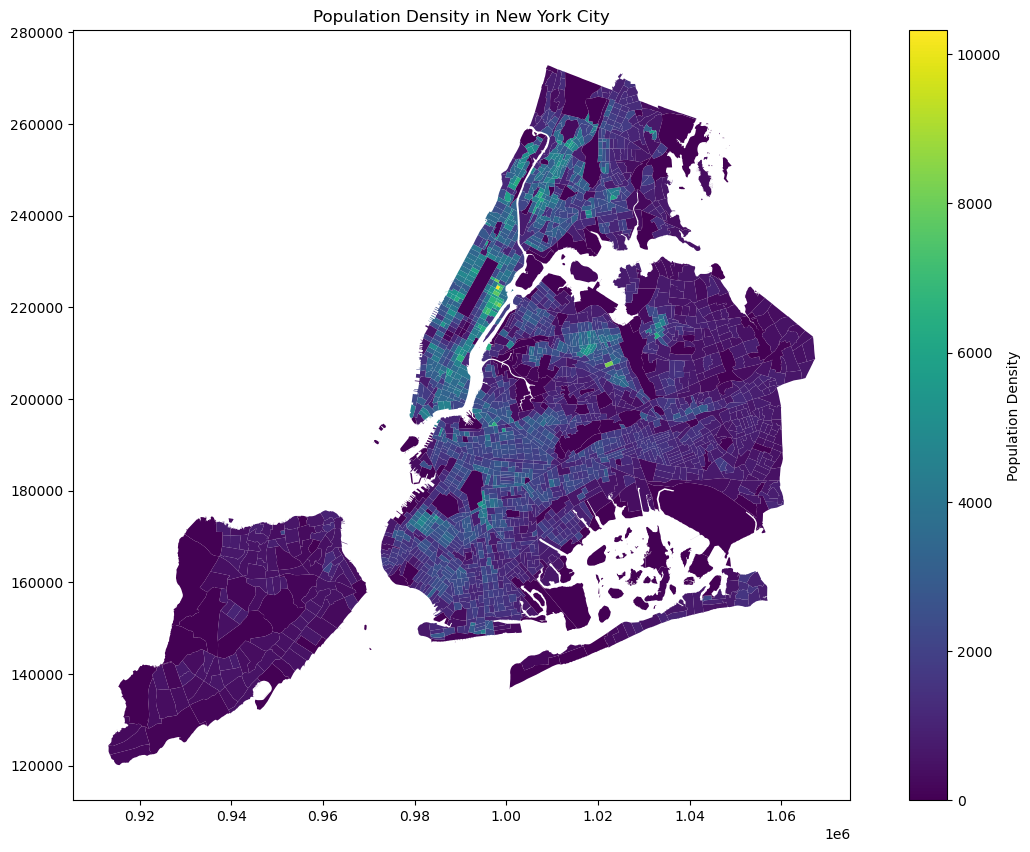

In [118]:
# Example: Calculate population density and add it as a column
merged_gdf['Population_Density'] = merged_gdf['P1_001N'] / merged_gdf['Shape_Area']

# Plot the GeoDataFrame and color by population density
fig, ax = plt.subplots(1, 1, figsize=(15,10))
merged_gdf.plot(column='Population_Density', ax=ax, legend=True, legend_kwds={'label': "Population Density", 'orientation': "vertical"})
ax.set_title('Population Density in New York City')
plt.show()